In [1]:
import scipy.stats
import numpy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import xarray as xr
import tqdm
import os
import pickle
from tqdm.notebook import tqdm


## set plotting style
sns.set()

# ## initialize random number generator
# rng = np.random.default_rng()

path = "/glade/work/alancelin/EVT_rossbypalooza/"
os.chdir(path)

from src.evt import *

## First Plot: Return time curve with 80 years of training data (using MC sampling)

In [11]:
# PARAMS 
n_train = 80
bounds = dict(c=[-5, 5], loc=[-5, 15], scale=[0.001, 10]) # SELECT YOUR BOUNDS

# SELECT YOUR DATA INSTEAD 
# Load data 
T = 7
A_test = pd.read_csv(f'/glade/work/alancelin/EVT_rossbypalooza/scripts/coldspells/data/A_test_T{T}.csv', index_col=0)
A_train_val = pd.read_csv(f'/glade/work/alancelin/EVT_rossbypalooza/scripts/coldspells/data/A_train_val_T{T}.csv', index_col=0)

X_train = - A_train_val.values.squeeze()
X_test = - A_test.values.squeeze()
X_train, len(X_test)

(array([-3.63789857,  1.45970286, -0.30284714, ..., -2.50665857,
        -0.70897143, -3.13726571]),
 53321)

In [12]:
## Empirical return period
tr_empirical, Xr_empirical = get_empirical_return_period(X_train)

## Fit model and get return levels
model_type = "gev"
if model_type == "gev":
    model_class = scipy.stats.genextreme
    thresh = None
model = fit_model(X_train, model_class, bounds)
Xr, tr = get_return_levels(model)

## Compute confidence interval
n_mc = 100

Xr_mean, Xr_median, Xr_lb, Xr_ub = compute_MC_return_period_bnds(
    X_test, model_class=model_class, bounds=bounds, n_train=n_train, n_mc=n_mc)
# Compute the same with Gaussian fit 
Xr_mean_gauss, Xr_median_gauss, Xr_lb_gauss, Xr_ub_gauss = compute_MC_return_period_bnds(
    X_test, model_class=scipy.stats.norm, bounds=bounds, n_train=n_train, n_mc=n_mc)

  0%|          | 0/100 [00:00<?, ?it/s]/glade/work/alancelin/EVT_rossbypalooza/src/evt.py:20: RuntimeWarning: Bounds provided for the following unrecognized parameters will be ignored: {'c'}
  params = scipy.stats.fit(dist=model_class, data=data, bounds=bounds).params
100%|██████████| 100/100 [00:02<00:00, 35.50it/s]


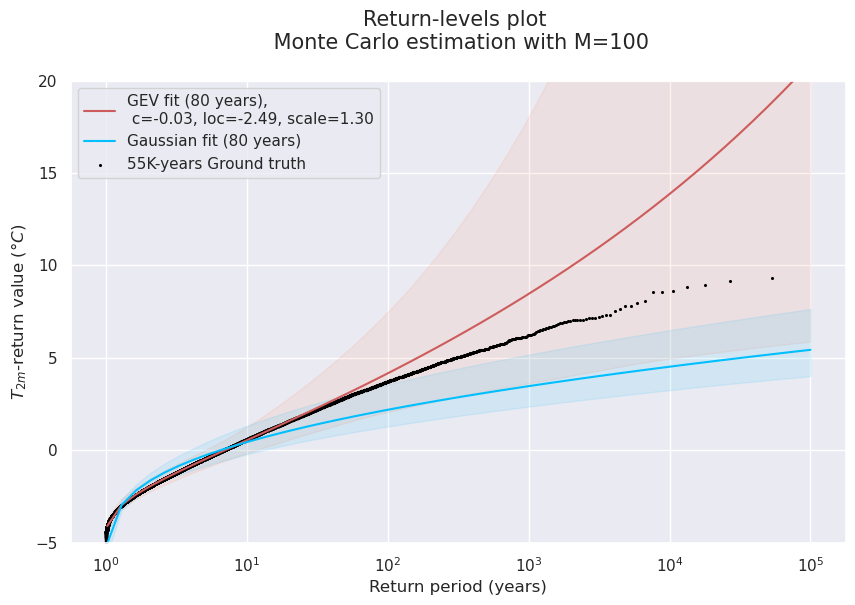

In [14]:
import seaborn as sns
sns.set()
fig, ax = plt.subplots(figsize=(10, 6))

## plot modeled return period
ax.plot(tr, Xr_mean, c="indianred", label=f"GEV fit ({n_train} years), \n c={model.args[0]:.2f}, loc={model.args[1]:.2f}, scale={model.args[2]:.2f}")
ax.fill_between(tr, Xr_ub, Xr_lb, color="coral", alpha=0.1)


## plot modeled return period
ax.plot(tr, Xr_mean_gauss, c="deepskyblue", label=f"Gaussian fit ({n_train} years)")
ax.fill_between(tr, Xr_ub_gauss, Xr_lb_gauss, alpha=0.1, color="deepskyblue")

## label axes
ax.set_xlabel("Return period (years)")
ax.set_ylabel(r"$T_{2m}$-return value ($°C$)") # MY DATA IS IN CELSIUS, but you can change it to whatever you want
ax.set_xscale("log")
ax.set_ylim(-5, 20)

# add the gound truth
t_test_r_empirical, X_test_r_empirical = get_empirical_return_period(X_test)
ax.scatter(t_test_r_empirical, X_test_r_empirical, c='black', s=1.5, label='55K-years Ground truth')

# # # compute negative log likelihood on the test set
# NLL_test = -model.logpdf(X_test).sum()/len(X_test)
# # print it in the plot in the bottom right corner
# ax.text(0.7, 0.2, f'test NLL={NLL_test:.2f}', transform=ax.transAxes)

plt.title(f"Return-levels plot \n Monte Carlo estimation with M={n_mc}", y = 1.05, fontsize=15)
plt.legend()
plt.show()

# Second plot: Boxplots of biais v.s number of training data

In [5]:
import importlib
import src.evt
importlib.reload(src.evt)
from src.evt import get_target_return_value, compute_MC_return_value
get_target_return_value(X_test, 1000)

(6.215210714285693, 53268)

In [6]:
n_train_list = [40, 80, 160, 320, 640, 1280, 5000, 10000]
n_mc = 100

target_return_period = 1000 # We should probably stick to 1000 years to compare our plots (but feel free to try other values for your own curiosity)
bounds = dict(c=[-5, 5], loc=[-5, 15], scale=[0.001, 10])

target_return_value = get_target_return_value(X_test, target_return_period)[0]

Xr_samples_list = []
Xr_samples_list_gauss = []



for n_train in tqdm(n_train_list):
    Xr_samples = compute_MC_return_value(X_test, model_class, bounds, n_train=n_train, n_mc=n_mc, return_periods=target_return_period)
    Xr_samples_list.append(Xr_samples)
    Xr_samples_gauss = compute_MC_return_value(X_test, scipy.stats.norm , bounds=None, n_train=n_train, n_mc=n_mc, return_periods=target_return_period)
    Xr_samples_list_gauss.append(Xr_samples_gauss)
    
Xr_samples_list = np.stack(Xr_samples_list, axis=0)
Xr_samples_list_gauss = np.stack(Xr_samples_list_gauss, axis=0)

 12%|█▎        | 1/8 [00:22<02:34, 22.06s/it]/glade/u/apps/opt/conda/envs/npl/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:3071: RuntimeWarning: overflow encountered in exp
  pex2 = np.exp(logpex2)
100%|██████████| 8/8 [04:40<00:00, 35.00s/it]


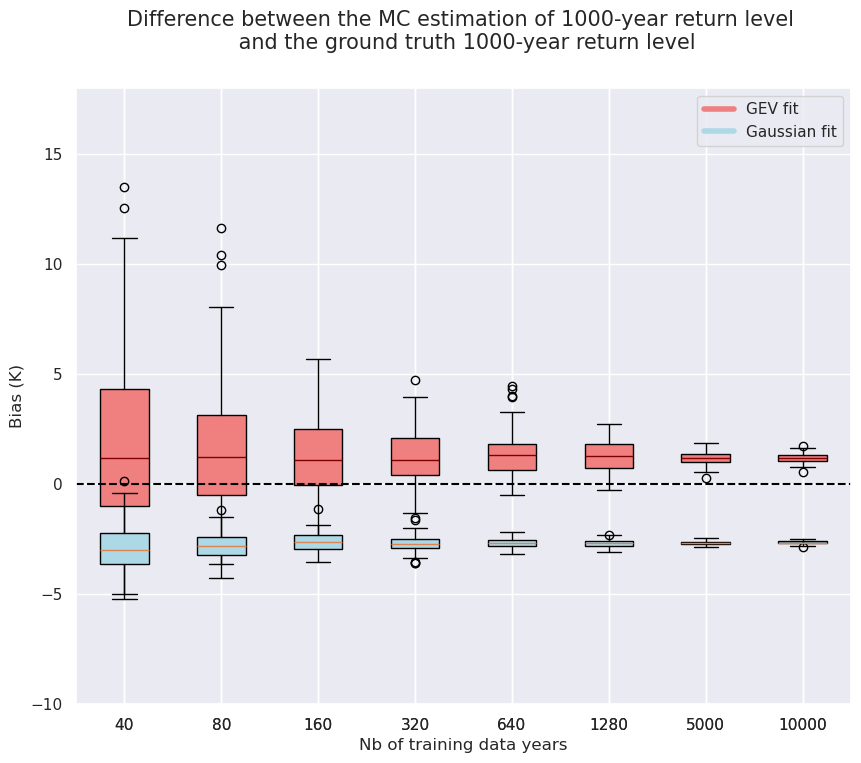

In [9]:
import seaborn as sns
sns.set()
# Create the box plot
fig, ax = plt.subplots(figsize=(10, 8))

bias = (-target_return_value + Xr_samples_list).T
# change color of median 
plt.boxplot(bias, vert=True, patch_artist=True, labels=n_train_list, boxprops=dict(facecolor="lightcoral"), medianprops=dict(color="maroon")) #, label= 'Gaussian fit')

bias_gauss = (-target_return_value + Xr_samples_list_gauss).T
# change color for the gaussian model
plt.boxplot(bias_gauss, vert=True, patch_artist=True, labels=n_train_list, boxprops=dict(facecolor="lightblue")) #, label= 'Gaussian fit')

# Create custom handles for the legend
handles = [
    plt.Line2D([0], [0], color='lightcoral', lw=4, label='GEV fit'),
    plt.Line2D([0], [0], color='lightblue', lw=4, label='Gaussian fit')
]

# Add the legend
plt.legend(handles=handles, loc='upper right')

# Add title and labels
plt.title('Box plot of n_values')
plt.xlabel('Nb of training data years')
plt.ylabel(f'Bias (K)')
plt.title(f'Difference between the MC estimation of {target_return_period}-year return level \n and the ground truth {target_return_period}-year return level', y = 1.05, fontsize=15)
# plot a straight line at 0
plt.axhline(y=0, color='black', linestyle='--')
plt.ylim(-10, 18)

# Show the plot
plt.show()

In [8]:
np.median(bias, axis=0), np.median(bias_gauss, axis=0)

(array([1.17047901, 1.23250151, 1.12160624, 1.08644371, 1.33398025,
        1.27502092, 1.18203174, 1.19990066]),
 array([-2.96711967, -2.78709418, -2.63326739, -2.70030302, -2.66953947,
        -2.68407502, -2.66808262, -2.64794816]))